<a href="https://colab.research.google.com/github/sharsulkar/H1B_LCA_outcome_prediction/blob/main/prototyping/notebooks/06_sh_evaluate_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Evaluate model 
FY21 Q1 dataset will be used as a holdout test data to evaluate the performance of model trained on FY20Q1-Q4 data. The model has not seen this data so performance on this data will give an idea of the usability of this model in real-world application.

### Import libraries, custom functions and define preprocessing transform classes

In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd
from pickle import dump, load
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

In [2]:
#Custom transformer to drop rows based on filter
class droprows_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self):
      self.row_index = None # row index to drop
      self.inplace=True
      self.reset_index=True

    def fit( self, X, y=None):
      return self 
    
    def transform(self, X, y=None):
      self.row_index=X[~X.CASE_STATUS.isin(['Certified','Denied'])].index
      X.drop(index=self.row_index,inplace=self.inplace)
      if self.reset_index:
        X.reset_index(inplace=True,drop=True)
      return X

In [3]:
class buildfeatures_Transformer(BaseEstimator, TransformerMixin):
  def __init__(self, input_columns):
    self.input_columns=input_columns

  def date_diff(self,date1,date2):
    return date1-date2

  def is_USA(self,country):
    if country=='UNITED STATES OF AMERICA':
      USA_YN='Y' 
    else:
      USA_YN='N'
    return USA_YN

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    # Processing_Days and Validity_days
    X['PROCESSING_DAYS']=self.date_diff(X.DECISION_DATE, X.RECEIVED_DATE).dt.days
    X['VALIDITY_DAYS']=self.date_diff(X.END_DATE, X.BEGIN_DATE).dt.days

    # SOC_Codes
    '''
    #Removed as it is not an important feature for the current model
    X['SOC_CD2']=X.SOC_CODE.str.split(pat='-',n=1,expand=True)[0]
    X['SOC_CD4']=X.SOC_CODE.str.split(pat='-',n=1,expand=True)[1].str.split(pat='.',n=1,expand=True)[0]
    if X.SOC_CODE.str.split(pat='-',n=1,expand=True)[1].str.split(pat='.',n=1,expand=True).shape[1]==2:
      X['SOC_CD_ONET']=X.SOC_CODE.str.split(pat='-',n=1,expand=True)[1].str.split(pat='.',n=1,expand=True)[1]
    else:
      X['SOC_CD_ONET']='00'
      '''

    # USA_YN
    X['USA_YN']=X.EMPLOYER_COUNTRY.apply(self.is_USA)

    # Employer_Worksite_YN
    X['EMPLOYER_WORKSITE_YN']='Y'
    X.loc[X.EMPLOYER_POSTAL_CODE.ne(X.WORKSITE_POSTAL_CODE),'EMPLOYER_WORKSITE_YN']='N'

    # OES_YN
    X['OES_YN']='Y'
    X.iloc[X[~X.PW_OTHER_SOURCE.isna()].index,X.columns.get_loc('OES_YN')]='N'

    # SURVEY_YEAR
    X['SURVEY_YEAR']=pd.to_datetime(X.PW_OES_YEAR.str.split(pat='-',n=1,expand=True)[0]).dt.to_period('Y')
    PW_other_year=X[X.OES_YN=='N'].PW_OTHER_YEAR
    #Rename the series and update dataframe with series object
    PW_other_year.rename("SURVEY_YEAR",inplace=True)
    X.update(PW_other_year)

    # WAGE_ABOVE_PREVAILING_HR
    X['WAGE_PER_HR']=X.WAGE_RATE_OF_PAY_FROM
    #compute for Year
    X.iloc[X[X.WAGE_UNIT_OF_PAY=='Year'].index,X.columns.get_loc('WAGE_PER_HR')]=X[X.WAGE_UNIT_OF_PAY=='Year'].WAGE_RATE_OF_PAY_FROM/2067
    #compute for Month
    X.iloc[X[X.WAGE_UNIT_OF_PAY=='Month'].index,X.columns.get_loc('WAGE_PER_HR')]=X[X.WAGE_UNIT_OF_PAY=='Month'].WAGE_RATE_OF_PAY_FROM/172

    #initialize with WAGE_RATE_OF_PAY_FROM
    X['PW_WAGE_PER_HR']=X.PREVAILING_WAGE
    #compute for Year
    X.iloc[X[X.PW_UNIT_OF_PAY=='Year'].index,X.columns.get_loc('PW_WAGE_PER_HR')]=X[X.PW_UNIT_OF_PAY=='Year'].PREVAILING_WAGE/2067
    #compute for Month
    X.iloc[X[X.PW_UNIT_OF_PAY=='Month'].index,X.columns.get_loc('PW_WAGE_PER_HR')]=X[X.PW_UNIT_OF_PAY=='Month'].PREVAILING_WAGE/172

    X['WAGE_ABOVE_PW_HR']=X.WAGE_PER_HR-X.PW_WAGE_PER_HR

    return X

In [4]:
#Custom transformer to drop features for input feature list
class dropfeatures_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, inplace):
      self.columns = columns # list of categorical columns in input Dataframe
      self.inplace=True

    def fit( self, X, y=None):
      return self 
    
    def transform(self, X, y=None):
      X.drop(columns=self.columns,inplace=self.inplace)
      return X

In [5]:
#Custom transformer to compute Random Standard encoding for categorical features for incrementaly encoding data
class RSE_Transformer(BaseEstimator, TransformerMixin):
    #Class Constructor
    def __init__( self, cat_cols, categories=None, RSE=None ):
        self.cat_cols = cat_cols # list of categorical columns in input Dataframe
        self.categories = None # Array of unique non-numeric values in each categorical column
        self.RSE = None # Array of Random Standard encoding for each row in categories
        
    def fit( self, X, y=None ):
      #Get a list of all unique categorical values for each column
      if self.categories is None:
        self.categories = [X[column].unique() for column in cat_cols]

        #replace missing values and append missing value label to each column to handle missing values in test dataset that might not be empty in train dataset
        for i in range(len(self.categories)):
          if np.array(self.categories[i].astype(str)!=str(np.nan)).all():
            self.categories[i]=np.append(self.categories[i],np.nan)

        #compute RandomStandardEncoding 
        self.RSE=[np.random.normal(0,1,len(self.categories[i])) for i in range(len(self.cat_cols))]

      else:
        for i in range(len(self.cat_cols)):
          #append new unique categories to self.categories
          new_categories=list(set(X[self.cat_cols[i]].unique()).difference(set(self.categories[i])))
          if new_categories!=[]:
            #print('not empty') #replace with logging call
            #print('categories before append',len(categories[i])) #logging call
            self.categories[i]=np.append(self.categories[i],new_categories) #append new categories to the end
            new_RSE=np.random.normal(0,1,len(new_categories)) #generate new RSE values
            #regenrate if overlap found with existing encodings
            if set(new_RSE).issubset(set(self.RSE[i])): 
              #print('yes') #loggin call
              new_RSE=np.random.normal(0,1,len(new_categories))
            
            self.RSE[i]=np.append(self.RSE[i],new_RSE) #append new RSE values
          #print('new categories',len(new_categories)) #logging call
          #print('categories after append',len(categories[i]))
     
      return self 
    
    def transform(self, X, y=None):
      for i in range(len(self.cat_cols)):
        #Temporary measure to handle previously unseen values
        #replace unseen values with NaN
        X.loc[X[~X[(str(self.cat_cols[i]))].isin(self.categories[i])].index,(str(self.cat_cols[i]))]=np.NaN

        #replace seen values with encoding
        X.loc[:,(str(self.cat_cols[i]))].replace(dict(zip(self.categories[i], self.RSE[i])),inplace=True)
      return X    

    def inverse_transform(self,X):
      for i in range(len(self.cat_cols)):
        X.loc[:,(str(self.cat_cols[i]))].replace(dict(zip(self.RSE[i], self.categories[i])),inplace=True)
      return X

In [6]:
#custom transformer for incrementally scaling to standard scale using pooled mean and variance
class CustomStandardScaler(BaseEstimator, TransformerMixin):
  def __init__(self,mean=None,var=None,n_samples_seen=None,scale=None):
    self.mean=None #mean
    self.var=None
    self.n_samples_seen=None
    self.scale=None

  def compute_sample_mean(self,X):
    return np.mean(X,axis=0)

  def compute_sample_var(self,X):
    return np.var(X,axis=0)

  def compute_sample_size(self,X):
    #assuming X is imputed, if there are null values, throw error aksing that X be imputed first
    return len(X)

  def compute_pooled_mean(self,X):
    #compute the sample mean and size
    sample_mean=self.compute_sample_mean(X)
    sample_count=self.compute_sample_size(X) 
    #compute pool mean
    pool_mean=(self.mean*self.n_samples_seen + sample_mean*sample_count)/(self.n_samples_seen + sample_count)

    return pool_mean

  def compute_pooled_var(self,X):
    #compute the sample var and size
    sample_var=self.compute_sample_var(X)
    sample_count=self.compute_sample_size(X) 
    #compute pool variance
    pool_var=(self.var*(self.n_samples_seen - 1) + sample_var*(sample_count - 1))/(self.n_samples_seen + sample_count - 2)

    return pool_var

  def fit(self,X):
    if self.mean is None:
      self.mean=self.compute_sample_mean(X)
    else: 
      self.mean=self.compute_pooled_mean(X)
    
    if self.var is None:
      self.var=self.compute_sample_var(X)
    else: 
      self.var=self.compute_pooled_var(X)

    if self.n_samples_seen is None:
      self.n_samples_seen=self.compute_sample_size(X) 
    else: 
      self.n_samples_seen+=self.compute_sample_size(X)
    return self

  def transform(self,X):
    return (X-self.mean)/np.sqrt(self.var)

  def inverse_transform(self,X):
    return X*np.sqrt(self.var) + self.mean



In [7]:
def read_csv_to_list(filepath,header=None,squeeze=True):
  return list(pd.read_csv(filepath,header=None,squeeze=True))

### Load the saved pipeline objects and trained model

In [8]:
model=load(open('/content/drive/MyDrive/saved_models/H1B_LCA_prediction/final_batch_train.pkl','rb'))
all_preprocess=load(open('/content/drive/MyDrive/saved_models/H1B_LCA_prediction/pipeline_batch_train.pkl','rb'))
build_feature_pipe=load(open('/content/drive/MyDrive/saved_models/H1B_LCA_prediction/build_feature_pipe_batch_train.pkl','rb'))

In [ ]:
## Do not execute - this is a one time change that was needed becayse one of the required field name changed from 'H-1B_DEPENDENT' to 'H1B_DEPENDENT' in FY21 Q1 dataset
'''
required_features=read_csv_to_list('https://raw.githubusercontent.com/sharsulkar/H1B_LCA_outcome_prediction/main/data/processed/required_features.csv',header=None,squeeze=True)
required_features_test=required_features
required_features_test[-3]='H1B_DEPENDENT'
required_features_test

data_df=pd.read_excel('/content/drive/MyDrive/Datasets/H1B_LCA_prediction/LCA_Disclosure_Data_FY2021_Q1.xlsx',usecols=required_features_test)

#one of the required field name changed from 'H-1B_DEPENDENT' to 'H1B_DEPENDENT'
data_df.rename(columns={"H1B_DEPENDENT": "H-1B_DEPENDENT"},inplace=True)

data_df.to_excel('/content/drive/MyDrive/Datasets/H1B_LCA_prediction/LCA_Disclosure_Data_FY2021_Q1_updated.xlsx')
'''

### Load test data into a DataFrame

In [9]:
data_df=pd.read_excel('/content/drive/MyDrive/Datasets/H1B_LCA_prediction/LCA_Disclosure_Data_FY2021_Q1_updated.xlsx')
data_dfcopy=data_df.copy()

In [ ]:
data_df=data_dfcopy.copy()

### Apply preprocessing pipeline

In [10]:
fe_df=build_feature_pipe.transform(data_df)

In [11]:
#separate the target variable and encode
y_test=fe_df.pop('CASE_STATUS')
y_test.replace(['Certified','Denied'],[0,1],inplace=True)
np.unique(y_test)

array([0, 1])

In [12]:
#apply remaining preprocess pipeline to the semi processed dataframe
X_test=all_preprocess.transform(fe_df)
print(X_test.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


(75566, 25)


### Predict outcome and compute model performance metrics

In [13]:
#Predict model on test data and display f1-score and confusion matrix
y_pred=model.predict(X_test)
print(f1_score(y_true=y_test,y_pred=y_pred,average=None))
confusion_matrix(y_true=y_test,y_pred=y_pred)

[0.99914119 0.86054054]


array([[75039,    25],
       [  104,   398]])

### Plot feature importance and compare with training plot

In [14]:
cat_cols=read_csv_to_list('https://raw.githubusercontent.com/sharsulkar/H1B_LCA_outcome_prediction/main/data/processed/categorical_columns.csv',header=None,squeeze=True)
num_cols=read_csv_to_list('https://raw.githubusercontent.com/sharsulkar/H1B_LCA_outcome_prediction/main/data/processed/numeric_columns.csv',header=None,squeeze=True)

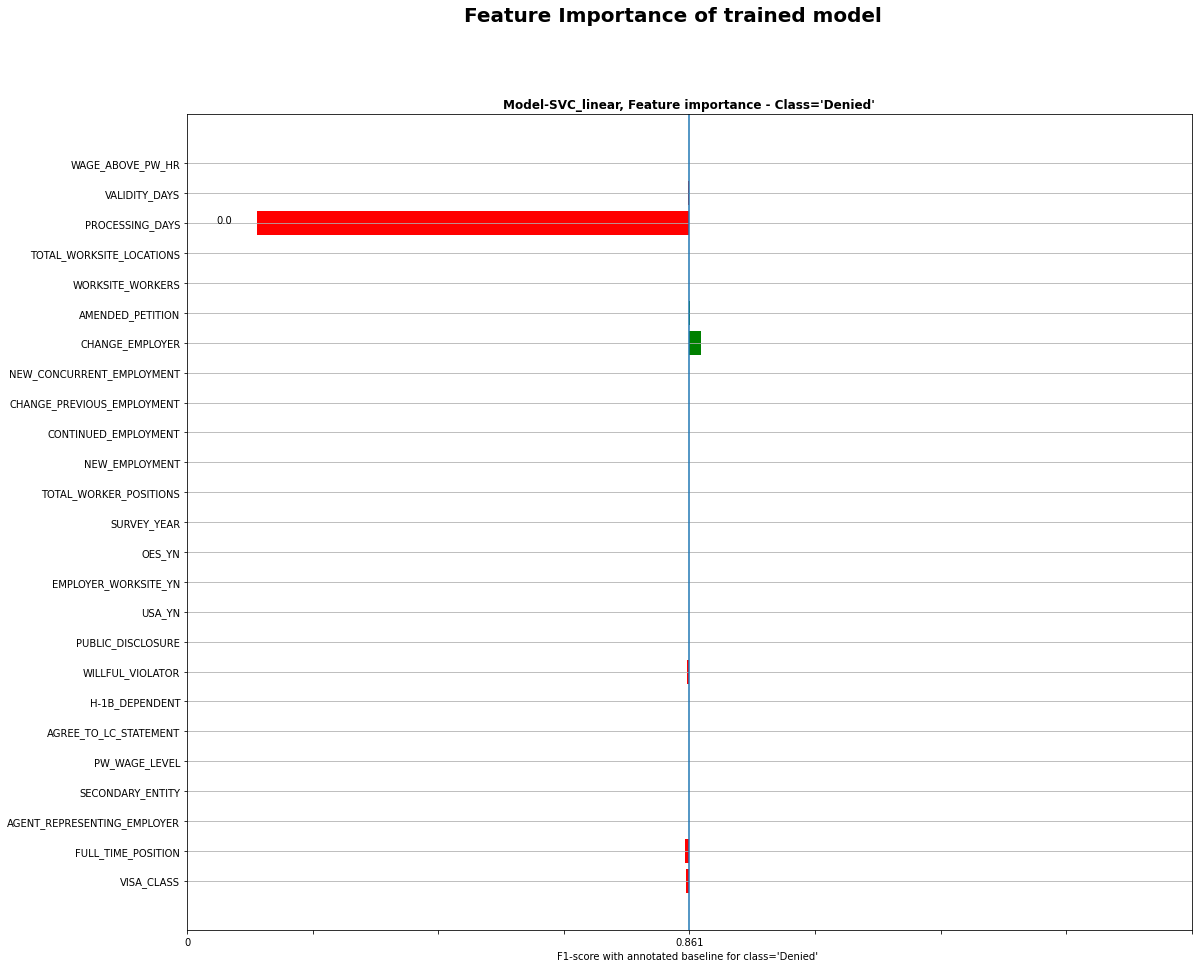

In [15]:
#for model in [svc,logistic,rfc,adaboost]:
j=0
fig = plt.figure(figsize=(18,15))
fig.suptitle('Feature Importance of trained model', fontsize=20, fontweight='bold')
model_name=['SVC_linear']
for model in [model]:
#for model in [svc_rbf,svc_poly]:
  j+=1
  feature_importance_df=pd.DataFrame(columns=['model','feature','metrics','baseline_diff'])

  baseline=f1_score(y_true=y_test,y_pred=model.predict(X_test),average=None)
  #print('baseline: ',baseline)
  for i in range(X_test.shape[1]):
    hide_feature_map=np.ones((X_test.shape[1]))
    hide_feature_map[i]=0
    X_hide_map=hide_feature_map*X_test
    y_pred=model.predict(X_hide_map)
    feature_score=f1_score(y_true=y_test,y_pred=y_pred,average=None)
    feature_importance_df.loc[feature_importance_df.shape[0]]=[model_name[j-1],np.append(cat_cols,num_cols)[i],np.round(feature_score,3),np.round((feature_score-baseline),3)]
    #print('Feature removed: ',np.append(cat_cols,num_cols)[i],', metrics ',f1_score(y_true=y_test,y_pred=y_pred,average=None))
  
  class1_diff=np.array([feature_importance_df.baseline_diff.values[i][1] for i in range(X_test.shape[1])])
  class1_metric=np.array([feature_importance_df.metrics.values[i][1] for i in range(X_test.shape[1])])
  #fig = plt.figure(figsize=(15,10))
  ax = plt.subplot(1,1,j)
  ax.set_title('Model-' + model_name[j-1] + ', Feature importance - Class=\'Denied\'',fontweight='bold')
  ax.grid(True,axis='y')
  ax.set(xlim=(-1, 1))
  ax.set_xticklabels(['0','','','',str(round(baseline[1],3))])
  ax.set_xlabel('F1-score with annotated baseline for class=\'Denied\' ')
  ax.axvline(x=0)
  ax.barh(width=class1_diff,y=feature_importance_df.feature.values,color=['g' if class1_diff[i] > 0 else 'r' for i in range(len(class1_diff))])
  
  if j%3==0:
    plt.setp(ax, yticklabels=[])

  #annotate only if metric value changes overthreshold
  for i in range(len(class1_diff)) :
    if np.abs(class1_diff[i])>0.2:
      ax.annotate(str(class1_metric[i]), xy=(class1_diff[i], feature_importance_df.feature.values[i]),xytext=(class1_diff[i]-0.08, feature_importance_df.feature.values[i]))

fig.savefig('/content/drive/MyDrive/feature_importance_testdata.png')